In [1]:
import os
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../../SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import  OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd
from numba import njit
import tifffile

In [55]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.05 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

additional_width = 0
raster_additional_width = 0

In [32]:
dirs = glob("../../single_cell_projection_diffraction/targeted_simulation_output/*iPSF*")
width = float(dirs[0].split("_iPSF")[0].split("/")[-1])
colour = dirs[0].split("_iPSF")[-1].split("_")[-1].split(".tiff")[0]

In [34]:

cells = []
for dir_ in tqdm(dirs):
    cell = {}
    a_cell = tifffile.imread(dir_)#
    projection = a_cell.sum(axis=0)
    width = float(dir_.split("_iPSF")[0].split("/")[-1])
    colour = dir_.split("_iPSF")[-1].split("_")[-1].split(".tiff")[0]

    cell["projection"] = projection
    cell["width"] = width
    cell["colour"] = colour
    cells.append(cell)

  0%|          | 0/52 [00:00<?, ?it/s]

In [37]:
for cell in cells:
    cell["projection"] /= cell["projection"].max()

In [40]:
from skimage import util

In [42]:
for cell in cells:
    cell["projection"] = util.img_as_uint(cell["projection"])


In [44]:
from skimage.transform import rotate

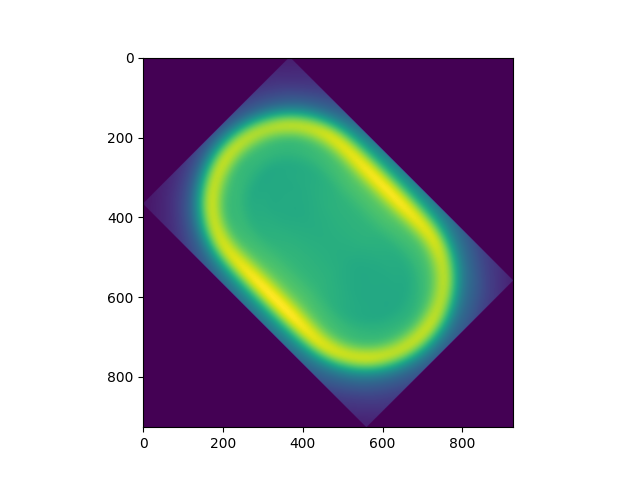

In [54]:
plt.imshow(rotate(cells[3]["projection"], 45, preserve_range=True, resize=True).astype(np.uint16))

In [75]:
pix_mic_conv = 0.065 / 15
resize_amount = 1
cell["width"]


2.1199999999999997

In [86]:
np.round(cell["width"], 2)

2.12

In [98]:
max_width = 3.1
cell_widths = np.arange(0.5, max_width, 0.1)+0.02

In [99]:
def get_OPL(width):
    _ = {}
    _[width] = np.pad(raster_membrane_cell_3d(3/pix_mic_conv, width/pix_mic_conv, 0), ((0,0), (50, 50), (50,50)))
    return _

In [100]:
OPL_cells = Parallel(n_jobs=-1)(delayed(get_OPL)(width) for width in tqdm(cell_widths))

  0%|          | 0/26 [00:00<?, ?it/s]

In [105]:
OPL_cells_dict = {}
for d in OPL_cells:
    OPL_cells_dict.update(d)

In [109]:
for cell in tqdm(cells):
    width = cell["width"]
    cell["OPL_cell"] = OPL_cells_dict[width]

  0%|          | 0/52 [00:00<?, ?it/s]

In [133]:
for cell in cells:
    assert cell["OPL_cell"].shape[1] == cell["projection"].shape[0]
    assert cell["OPL_cell"].shape[2] == cell["projection"].shape[1]

In [227]:
for cell in tqdm(cells):
    projection = cell["projection"]
    resized_projection = resize(projection, output_shape=(int(projection.shape[0]*pix_mic_conv * 15), int(projection.shape[1]*pix_mic_conv * 15)), preserve_range = True)
    membrane_mask = cell["OPL_cell"][cell["OPL_cell"].shape[0]//2]
    membrane_mask = resize(membrane_mask, output_shape=(int(membrane_mask.shape[0]*pix_mic_conv * 15), int(membrane_mask.shape[1]*pix_mic_conv * 15)), anti_aliasing_sigma=1) > 0
    mask = cell["OPL_cell"].sum(axis=0) > 0
    mask = resize(mask, output_shape=(int(mask.shape[0]*pix_mic_conv * 15), int(mask.shape[1]*pix_mic_conv * 15)), order = 0) > 0

    cell["mask"] = mask
    cell["membrane_mask"] = membrane_mask
    cell["resized_projection"] = resized_projection.astype(np.uint16)

  0%|          | 0/52 [00:00<?, ?it/s]

In [239]:
for i, cell in enumerate(cells):
    if cell["colour"] == "green":
        img = Image.fromarray(cell["resized_projection"])
        img.save(f"single_projected_cells_for_DL_green_masks/{str(i).zfill(2)}.png")
        img.save(f"single_projected_cells_for_DL_green_membranemasks/{str(i).zfill(2)}.png")
        mask = Image.fromarray(cell["mask"])
        mask.save(f"single_projected_cells_for_DL_green_masks/{str(i).zfill(2)}_masks.png")
        membrane_mask = Image.fromarray(cell["membrane_mask"])
        membrane_mask.save(f"single_projected_cells_for_DL_green_membranemasks/{str(i).zfill(2)}_masks.png")
    if cell["colour"] == "darkred":
        img = Image.fromarray(cell["resized_projection"])
        img.save(f"single_projected_cells_for_DL_darkred_masks/{str(i).zfill(2)}.png")
        img.save(f"single_projected_cells_for_DL_darkred_membranemasks/{str(i).zfill(2)}.png")
        mask = Image.fromarray(cell["mask"])
        mask.save(f"single_projected_cells_for_DL_darkred_masks/{str(i).zfill(2)}_masks.png")
        membrane_mask = Image.fromarray(cell["membrane_mask"])
        membrane_mask.save(f"single_projected_cells_for_DL_darkred_membranemasks/{str(i).zfill(2)}_masks.png")

In [240]:
import pickle

In [241]:
with open('cells_dict.pickle', 'wb') as handle:
    pickle.dump(cells, handle, protocol=pickle.HIGHEST_PROTOCOL)